# Facenet-pytorch viz

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
import rasterio as rio
import sklearn as sk
import scipy as sc
import seaborn as sns
import seaborn_image as isns

In [2]:
import tqdm
#from tqdm import tqdm
from tqdm.notebook import tqdm # for notebooks
tqdm.pandas()

In [3]:
import pickle
import gc
collectAll = lambda : gc.collect(0) + gc.collect(1) + gc.collect(2)

In [4]:
#from pandarallel import pandarallel
#pandarallel.initialize(progress_bar=True)

In [5]:
#import itables
#from itables import show

In [6]:
from collections import namedtuple
import itertools
from itertools import product

In [7]:
from skimage.feature import graycomatrix
from skimage.feature import graycoprops
from math import pi

In [8]:
import PIL as pil
from PIL import Image, ImageDraw

In [9]:
import geopy as gp

In [10]:
#import papermill as pm

In [11]:
import math

In [12]:
import matplotlib
matplotlib.rcParams["image.origin"] = 'upper'

In [13]:
import os

In [14]:
import functools

In [15]:
import facenet_pytorch

## Load our model

In [16]:
import torch
import torchvision
from einops import rearrange, reduce, repeat

In [17]:
torch.cuda.is_available()

True

In [18]:
device = torch.device('cuda')

In [19]:
model = facenet_pytorch.InceptionResnetV1(pretrained='vggface2').eval()

In [20]:
model = model.to(device)

## Utility functions

In [21]:
def whiten_image(x):
    return (x-x.mean(axis=(0,1), keepdims=True))/x.std(axis=(0,1), keepdims=True)

In [22]:
df = pd.read_pickle('df_intermediate_embeds.pickle')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Columns: 521 entries, index to 511
dtypes: float32(512), int64(5), object(4)
memory usage: 138.8+ KB


In [24]:
bands = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi', 'chm']
props = ['mean_no_glcm', 'mean', 'contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']

In [25]:
channels = [bands.index(i) for i in ['wr', 'wg', 'wb', *(('nir',)*3)]]

## Non-finetuned facenet outputs

In [26]:
df['whitened'] = df['crop'].progress_apply(lambda x: torchvision.transforms.functional.resize(
    torch.Tensor(rearrange(whiten_image(x[:,:,channels[:3]]), '(b h) w c -> b c h w', b=1)), (160, 160), antialias=True))

  0%|          | 0/67 [00:00<?, ?it/s]

In [27]:
with torch.no_grad():
    df['embeds'] = df['whitened'].progress_apply(lambda x: model(x.to(device)).cpu())

  0%|          | 0/67 [00:00<?, ?it/s]

In [31]:
embeds = df['embeds'].progress_apply(lambda x: pd.Series(x.detach().flatten()))

  0%|          | 0/67 [00:00<?, ?it/s]

In [32]:
df = pd.concat((df[[i for i in df.columns if i != 'embeds']], embeds), axis=1)

In [33]:
df.to_pickle('df_intermediate_embeds.pickle')

In [29]:
df_nv = df.drop(['crop', 'whitened'], axis=1)

In [30]:
X = df_nv.iloc[:,7:]

In [31]:
y = df_nv['name']

## UMAP our previous outputs

In [199]:
from umap import UMAP

In [200]:
train = df_nv[df_nv['src'] == '10May2021']
test = df_nv[df_nv['src'] == '18Dec2020']

In [201]:
X_train, X_test = train.iloc[:,7:], test.iloc[:,7:]
y_train, y_test = train['name'], test['name']

In [202]:
reducer = UMAP(n_components=2, n_neighbors=5, min_dist=0.1, metric='euclidean')

In [203]:
reducer.fit(X)
X_train_trans = reducer.transform(X_train)
X_test_trans = reducer.transform(X_test)

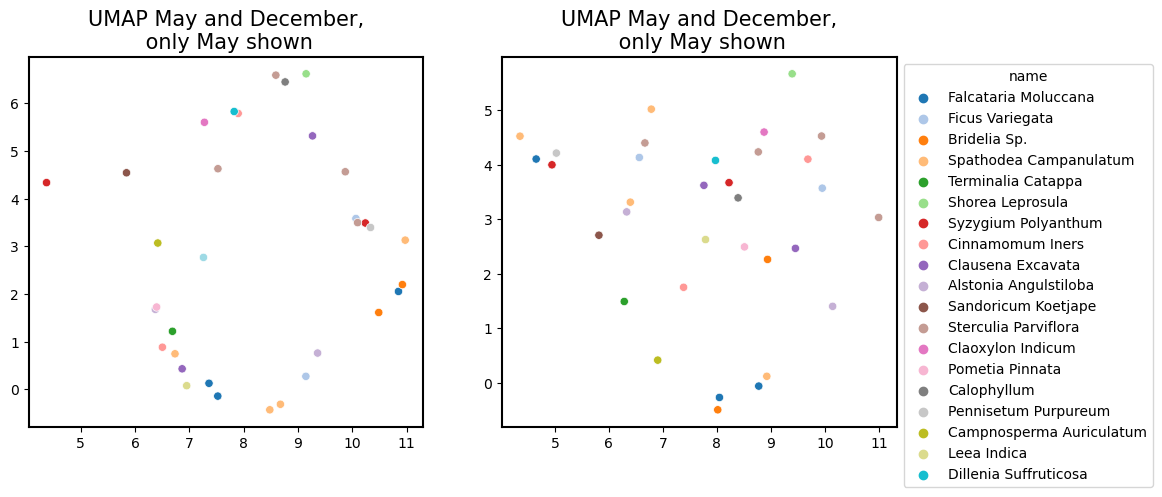

In [204]:
fig, ax = plt.subplots(1, 2, figsize=(5.6*2, 4.8))
sns.scatterplot(x=X_train_trans[:,0],
                y=X_train_trans[:,1],
                hue=y_train,
                palette='tab20',
                legend=False,
                ax=ax[0])
ax[0].set_title("UMAP May and December,\n only May shown")
sns.scatterplot(x=X_test_trans[:,0],
                y=X_test_trans[:,1],
                hue=y_test,
                palette='tab20',
                ax=ax[1])
ax[1].set_title("UMAP May and December,\n only May shown")
sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))

## Compare to a PCA

In [205]:
from sklearn.decomposition import PCA

In [206]:
reducer = PCA(n_components=2)

In [207]:
X_trans = reducer.fit_transform(X)

In [208]:
reducer.fit(X)
X_train_trans = reducer.transform(X_train)
X_test_trans = reducer.transform(X_test)

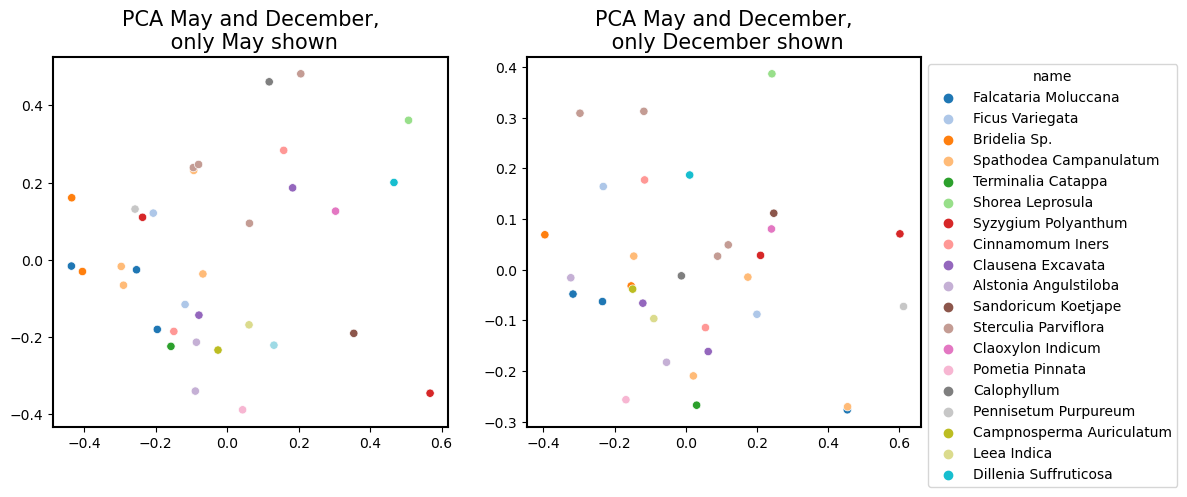

In [209]:
fig, ax = plt.subplots(1, 2, figsize=(5.6*2, 4.8))
sns.scatterplot(x=X_train_trans[:,0],
                y=X_train_trans[:,1],
                hue=y_train,
                palette='tab20',
                legend=False,
                ax=ax[0])
ax[0].set_title("PCA May and December,\n only May shown")
sns.scatterplot(x=X_test_trans[:,0],
                y=X_test_trans[:,1],
                hue=y_test,
                palette='tab20',
                ax=ax[1])
ax[1].set_title("PCA May and December,\n only December shown")
sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))

## Compare to an LDA

In [211]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [212]:
reducer = LinearDiscriminantAnalysis(n_components=2)

In [213]:
reducer.fit(X_train, y_train)
X_train_trans = reducer.transform(X_train)
X_test_trans = reducer.transform(X_test)

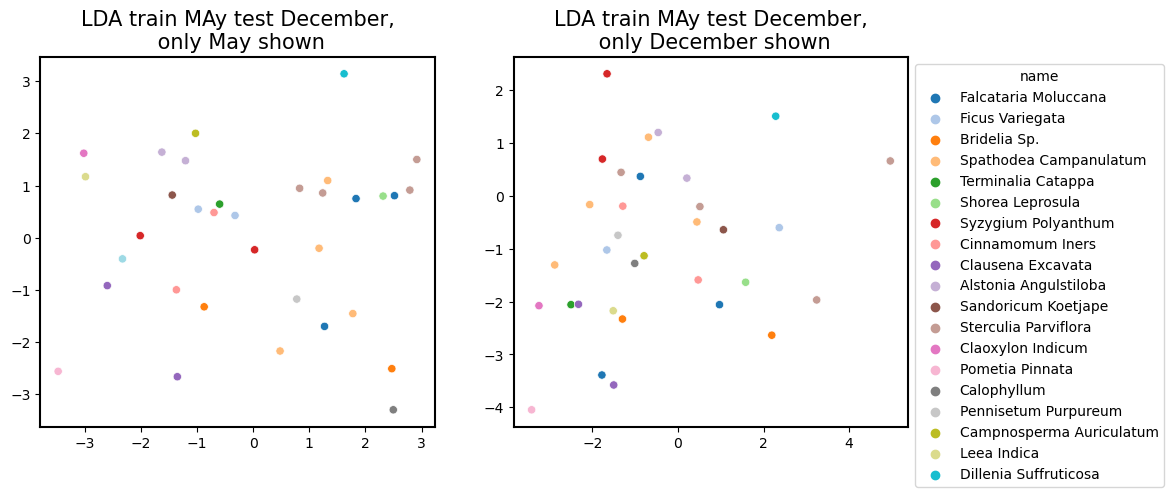

In [214]:
fig, ax = plt.subplots(1, 2, figsize=(5.6*2, 4.8))
sns.scatterplot(x=X_train_trans[:,0],
                y=X_train_trans[:,1],
                hue=y_train,
                palette='tab20',
                legend=False,
                ax=ax[0])
ax[0].set_title("LDA train MAy test December,\n only May shown")
sns.scatterplot(x=X_test_trans[:,0],
                y=X_test_trans[:,1],
                hue=y_test,
                palette='tab20',
                ax=ax[1])
ax[1].set_title("LDA train MAy test December,\n only December shown")
sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))

## Use Aaron's model instead

### What is the shape of each model? Which one matches the paper?

In [62]:
import tensorflow as tf

#### Base model

In [112]:
reader = tf.train.load_checkpoint('../weights/weights/ckpt/')

In [113]:
shape_from_key = reader.get_variable_to_shape_map()
dtype_from_key = reader.get_variable_to_dtype_map()

In [114]:
display(reader.get_tensor('model/conversion_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/conversion_layer_1/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/conversion_layer_2/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/embedding_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)

(3, 3, 10, 10)

(1, 1, 7, 3)

(3, 3, 10, 7)

(73728, 128)

In [101]:
sorted(shape_from_key.keys())

['_CHECKPOINTABLE_OBJECT_GRAPH',
 'epoch/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-0/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/moving_mean/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-10/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-100/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/moving_mean/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-102/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-103/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-103/moving_mean/.ATTR

#### ckpt_24_1806

In [116]:
reader = tf.train.load_checkpoint('../weights/weights/ckpt_24_1806/')

In [117]:
shape_from_key = reader.get_variable_to_shape_map()
dtype_from_key = reader.get_variable_to_dtype_map()

In [118]:
display(reader.get_tensor('model/conversion_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/conversion_layer_1/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/conversion_layer_2/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/conversion_layer_3/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/conversion_layer_4/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/embedding_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)

(3, 3, 24, 24)

(1, 1, 6, 3)

(3, 3, 24, 18)

(3, 3, 18, 12)

(3, 3, 12, 6)

(73728, 128)

In [106]:
sorted(shape_from_key.keys())

['_CHECKPOINTABLE_OBJECT_GRAPH',
 'epoch/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-0/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/moving_mean/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-10/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-100/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/moving_mean/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-102/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-103/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-103/moving_mean/.ATTR

#### ckpt_all_64

In [120]:
reader = tf.train.load_checkpoint('../weights/weights/ckpt_all_64/')

In [121]:
shape_from_key = reader.get_variable_to_shape_map()
dtype_from_key = reader.get_variable_to_dtype_map()

In [122]:
display(reader.get_tensor('model/conversion_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/conversion_layer_1/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/conversion_layer_2/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/embedding_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)

(3, 3, 64, 32)

(3, 3, 32, 16)

(1, 1, 16, 3)

(73728, 128)

In [123]:
sorted(shape_from_key.keys())

['_CHECKPOINTABLE_OBJECT_GRAPH',
 'epoch/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-0/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/moving_mean/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-10/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-100/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/moving_mean/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-102/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-103/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-103/moving_mean/.ATTR

#### ckpt_highest

In [128]:
reader = tf.train.load_checkpoint('../weights/weights/ckpt_highest/')

In [129]:
shape_from_key = reader.get_variable_to_shape_map()
dtype_from_key = reader.get_variable_to_dtype_map()

In [130]:
display(reader.get_tensor('model/conversion_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/conversion_layer_1/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/conversion_layer_2/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/embedding_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)

(3, 3, 10, 10)

(1, 1, 7, 3)

(3, 3, 10, 7)

(73728, 128)

In [131]:
sorted(shape_from_key.keys())

['_CHECKPOINTABLE_OBJECT_GRAPH',
 'epoch/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-0/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/moving_mean/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-10/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-100/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/moving_mean/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-102/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-103/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-103/moving_mean/.ATTR

#### ckpt_main

In [132]:
reader = tf.train.load_checkpoint('../weights/weights/ckpt_main/')

In [133]:
shape_from_key = reader.get_variable_to_shape_map()
dtype_from_key = reader.get_variable_to_dtype_map()

In [134]:
display(reader.get_tensor('model/conversion_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/conversion_layer_1/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/conversion_layer_2/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/embedding_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)

(3, 3, 10, 10)

(1, 1, 7, 3)

(3, 3, 10, 7)

(73728, 128)

In [135]:
sorted(shape_from_key.keys())

['_CHECKPOINTABLE_OBJECT_GRAPH',
 'epoch/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-0/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/moving_mean/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-10/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-100/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/moving_mean/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-102/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-103/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-103/moving_mean/.ATTR

#### ckpt_top_10_1806

In [136]:
reader = tf.train.load_checkpoint('../weights/weights/ckpt_top_10_1806/')

In [137]:
shape_from_key = reader.get_variable_to_shape_map()
dtype_from_key = reader.get_variable_to_dtype_map()

In [138]:
display(reader.get_tensor('model/conversion_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/conversion_layer_1/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/conversion_layer_2/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/embedding_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)

(3, 3, 10, 10)

(1, 1, 7, 3)

(3, 3, 10, 7)

(73728, 128)

In [139]:
sorted(shape_from_key.keys())

['_CHECKPOINTABLE_OBJECT_GRAPH',
 'epoch/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-0/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/moving_mean/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-10/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-100/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/moving_mean/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-102/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-103/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-103/moving_mean/.ATTR

#### ckpt_top_mean_base_1806

In [140]:
reader = tf.train.load_checkpoint('../weights/weights/ckpt_top_mean_base_1806/')

In [141]:
shape_from_key = reader.get_variable_to_shape_map()
dtype_from_key = reader.get_variable_to_dtype_map()

In [142]:
display(reader.get_tensor('model/conversion_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/conversion_layer_1/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/conversion_layer_2/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/embedding_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)

(3, 3, 10, 10)

(1, 1, 7, 3)

(3, 3, 10, 7)

(73728, 128)

In [143]:
sorted(shape_from_key.keys())

['_CHECKPOINTABLE_OBJECT_GRAPH',
 'epoch/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-0/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/moving_mean/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-10/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-100/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/moving_mean/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-102/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-103/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-103/moving_mean/.ATTR

#### ckpt_top_mean_base_2306

In [154]:
reader = tf.train.load_checkpoint('../weights/weights/ckpt_top_mean_base_2306/')

In [155]:
shape_from_key = reader.get_variable_to_shape_map()
dtype_from_key = reader.get_variable_to_dtype_map()

In [156]:
display(reader.get_tensor('model/conversion_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/conversion_layer_1/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/conversion_layer_2/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/embedding_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)

(3, 3, 10, 10)

(1, 1, 7, 3)

(3, 3, 10, 7)

(73728, 128)

In [157]:
sorted(shape_from_key.keys())

['_CHECKPOINTABLE_OBJECT_GRAPH',
 'epoch/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-0/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/moving_mean/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-10/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-100/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/moving_mean/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-102/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-103/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-103/moving_mean/.ATTR

#### ckpt_top16_1806

In [144]:
reader = tf.train.load_checkpoint('../weights/weights/ckpt_top16_1806/')

In [145]:
shape_from_key = reader.get_variable_to_shape_map()
dtype_from_key = reader.get_variable_to_dtype_map()

In [148]:
display(reader.get_tensor('model/conversion_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/conversion_layer_1/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/conversion_layer_2/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/conversion_layer_3/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/embedding_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)

(3, 3, 16, 16)

(1, 1, 7, 3)

(3, 3, 10, 7)

(3, 3, 16, 10)

(73728, 128)

In [147]:
sorted(shape_from_key.keys())

['_CHECKPOINTABLE_OBJECT_GRAPH',
 'epoch/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-0/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/moving_mean/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-10/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-100/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/moving_mean/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-102/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-103/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-103/moving_mean/.ATTR

#### glcm_10

In [149]:
reader = tf.train.load_checkpoint('../weights/weights/glcm_10/')

In [150]:
shape_from_key = reader.get_variable_to_shape_map()
dtype_from_key = reader.get_variable_to_dtype_map()

In [153]:
display(reader.get_tensor('model/conversion_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/conversion_layer_1/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/conversion_layer_2/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)
display(reader.get_tensor('model/embedding_layer/kernel/.ATTRIBUTES/VARIABLE_VALUE').shape)

(3, 3, 10, 10)

(1, 1, 7, 3)

(3, 3, 10, 7)

(73728, 128)

In [152]:
sorted(shape_from_key.keys())

['_CHECKPOINTABLE_OBJECT_GRAPH',
 'epoch/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-0/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/moving_mean/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-1/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-10/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-100/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/moving_mean/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-101/moving_variance/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-102/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-103/beta/.ATTRIBUTES/VARIABLE_VALUE',
 'model/base_model/layer_with_weights-103/moving_mean/.ATTR